In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    classification_report, roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

os.environ['LOKY_MAX_CPU_COUNT'] = '4'

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np


In [3]:
# Define the data types as a dictionary
dtypes = {
    'census_tract': 'float32',
    'action_taken': 'int32',
    'loan_type': 'int32',
    'lien_status': 'int32',
    'reverse_mortgage': 'int32',
    'open_end_line_of_credit': 'int32',
    'loan_amount': 'int32',
    'combined_loan_to_value_ratio': 'int32',
    'interest_rate': 'float32',
    'total_loan_costs': 'int32',
    'origination_charges': 'int32',
    'loan_term': 'int32',
    'negative_amortization': 'int32',
    'interest_only_payment': 'int32',
    'balloon_payment': 'int32',
    'other_nonamortizing_features': 'int32',
    'property_value': 'float32',
    'occupancy_type': 'int32',
    'manufactured_home_secured_property_type': 'int32',
    'manufactured_home_land_property_interest': 'int32',
    'total_units': 'int32',
    'income': 'float32',
    'debt_to_income_ratio': 'int32',
    'applicant_credit_score_type': 'int32',
    'co_applicant_credit_score_type': 'int32',
    'applicant_sex': 'int32',
    'co_applicant_sex': 'int32',
    'applicant_age': 'int32',
    'co_applicant_age': 'int32',
    'aus_1': 'int32',
    'applicant_race_1': 'float32',
    'applicant_race_2': 'float32',
    'co_applicant_race_1': 'float32',
    'co_applicant_race_2': 'float32',
    'applicant_ethnicity_1': 'float32',
    'co_applicant_ethnicity_1': 'float32'
}

In [4]:
# Read the CSV file with specified data types
df = pd.read_csv('10_all_numerical_32bit.csv', dtype=dtypes, low_memory=False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   census_tract                              49688 non-null  float32
 1   action_taken                              49688 non-null  int32  
 2   loan_type                                 49688 non-null  int32  
 3   lien_status                               49688 non-null  int32  
 4   reverse_mortgage                          49688 non-null  int32  
 5   open_end_line_of_credit                   49688 non-null  int32  
 6   loan_amount                               49688 non-null  int32  
 7   combined_loan_to_value_ratio              49688 non-null  int32  
 8   interest_rate                             49688 non-null  float32
 9   total_loan_costs                          49688 non-null  int32  
 10  origination_charges               

# Correlations

In [6]:
df.corr()

,census_tract,action_taken,loan_type,lien_status,reverse_mortgage,open_end_line_of_credit,loan_amount,combined_loan_to_value_ratio,interest_rate,total_loan_costs,...,applicant_ethnicity_1,co_applicant_ethnicity_1,applicant_race_1,applicant_race_2,co_applicant_race_1,co_applicant_race_2,applicant_sex,co_applicant_sex,applicant_age,co_applicant_age
census_tract,1.000000,-0.010374,0.021518,0.014893,NaN,-0.002426,-0.159222,-0.054574,0.035601,0.009716,...,0.091058,0.093301,-0.003795,-0.000508,-0.004311,-0.013998,0.020021,-0.017649,-0.052710,-0.049247
action_taken,-0.010374,1.000000,0.027268,0.049751,NaN,-0.031814,-0.062367,0.087869,-0.174062,-0.122661,...,-0.104209,-0.100532,-0.120205,0.006398,-0.122307,-0.000260,0.062126,-0.057661,0.061202,0.065045
loan_type,0.021518,0.027268,1.000000,-0.026027,NaN,0.007346,-0.088577,0.003478,-0.001411,0.160136,...,-0.017185,-0.024293,-0.036319,-0.000230,-0.033640,-0.004624,-0.034768,0.038648,0.008013,0.006818
lien_status,0.014893,0.049751,-0.026027,1.000000,NaN,-0.251346,-0.085045,0.073552,0.062080,-0.005084,...,-0.031933,-0.030739,-0.013824,-0.001910,-0.009587,-0.004700,0.011449,-0.009106,-0.019944,-0.005342
reverse_mortgage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
open_end_line_of_credit,-0.002426,-0.031814,0.007346,-0.251346,NaN,1.000000,0.018727,0.004411,0.005538,0.003902,...,0.008645,0.003611,0.005726,0.001427,0.005750,0.001281,0.001746,-0.006394,-0.001523,0.004559
loan_amount,-0.159222,-0.062367,-0.088577,-0.085045,NaN,0.018727,1.000000,-0.046679,-0.255265,0.127638,...,0.088995,0.087199,0.073988,0.008501,0.073789,0.015403,-0.109001,0.088725,-0.065814,-0.084385
combined_loan_to_value_ratio,-0.054574,0.087869,0.003478,0.073552,NaN,0.004411,-0.046679,1.000000,-0.080049,-0.062723,...,-0.037179,-0.036359,-0.007098,0.001626,-0.004974,-0.002691,-0.011313,0.012460,0.156257,0.148348
interest_rate,0.035601,-0.174062,-0.001411,0.062080,NaN,0.005538,-0.255265,-0.080049,1.000000,-0.067143,...,-0.041113,-0.038698,-0.011325,-0.001999,-0.009839,-0.006775,0.034959,-0.027634,0.028422,0.032719
total_loan_costs,0.009716,-0.122661,0.160136,-0.005084,NaN,0.003902,0.127638,-0.062723,-0.067143,1.000000,...,-0.010199,-0.005859,0.010164,-0.011796,0.011487,-0.002682,-0.018850,0.013513,-0.069069,-0.067892


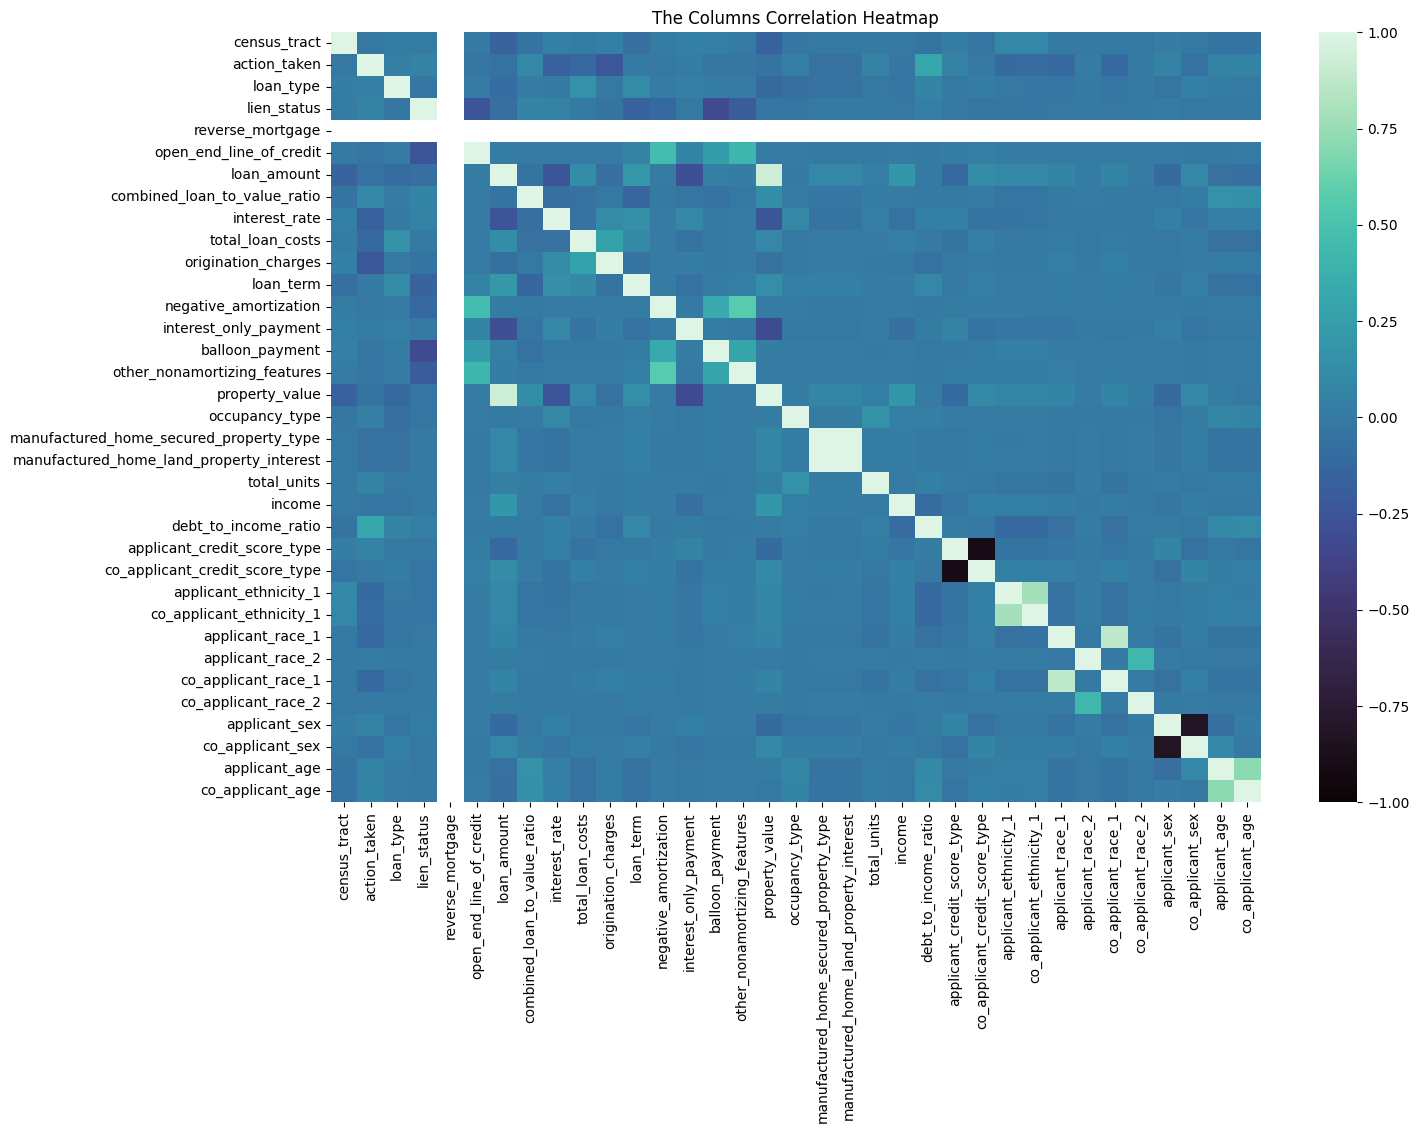

In [7]:
plt.figure(figsize=(15,10))
plt.title('The Columns Correlation Heatmap')
sns.heatmap(df.corr(),cmap='mako', annot=False, vmin=-1, vmax=1);

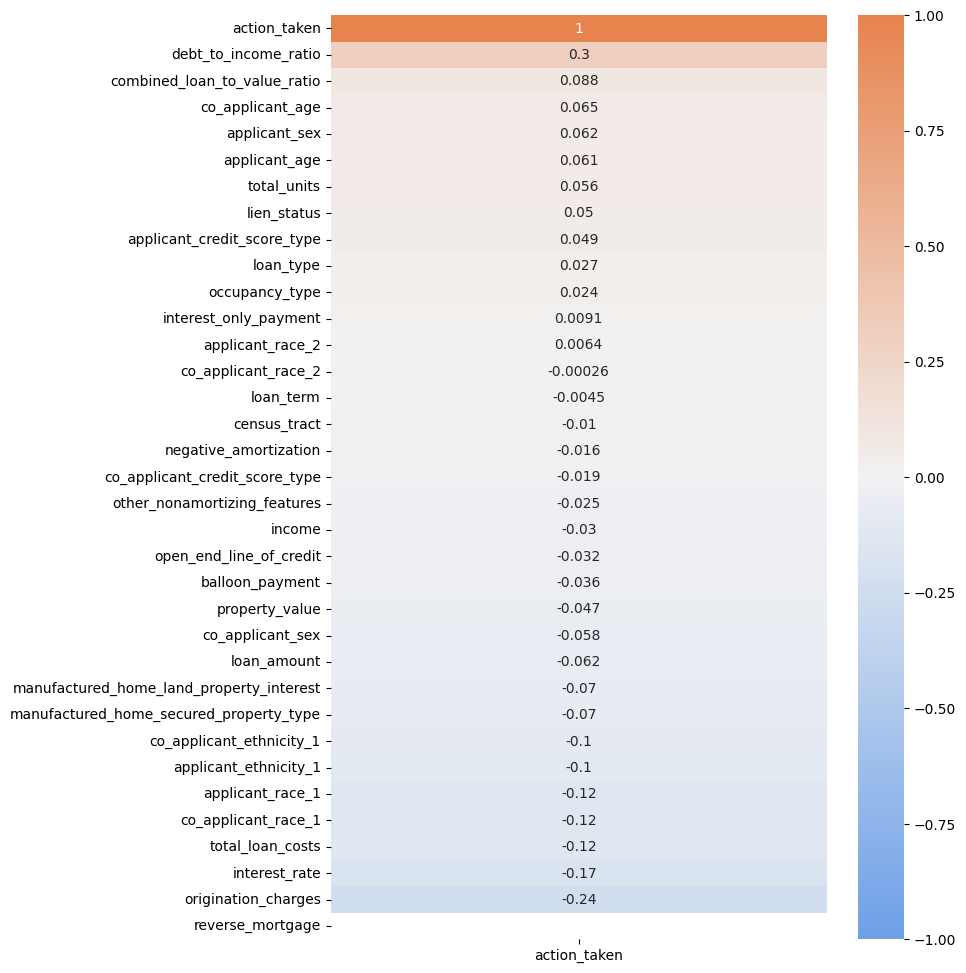

In [8]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['action_taken']].sort_values(by='action_taken', ascending=False), vmin=-1, vmax=1, annot=True, cmap=sns.diverging_palette(250, 30, l=65, as_cmap=True))

In [55]:
df['applicant_sex'].value_counts()

applicant_sex
1    35620
2    14030
6       21
3       17
Name: count, dtype: int64

In [52]:
# Specify the conditions for the columns and values
conditions = {
    'applicant_age': 1,
    'applicant_race_2': 5.0,
    'co_applicant_ethnicity_1': 2.0,
    'co_applicant_race_1': 5.0,
    'co_applicant_race_2': 5.0,
}

# Create a mask for filtering rows based on conditions
mask = [True] * len(df)

for column, value in conditions.items():
    if isinstance(value, tuple):
        mask = mask & ((df[column] >= value[0]) & (df[column] <= value[1]))
    else:
        mask = mask & (df[column] == value)

# Use the mask to filter the DataFrame and retrieve the specific record
specific_records_df = df[mask]

# Check if there are any matching records
if not specific_records_df.empty:
    # Print the first matching record
    specific_record_df = specific_records_df.iloc[3]

    # Create a DataFrame from the data
    table_df = pd.DataFrame(specific_record_df)

    # Display the table
    print(table_df)
    
else:
    print("No matching record found.")

                                                    25
census_tract                              4.904901e+10
action_taken                              3.000000e+00
loan_type                                 2.000000e+00
lien_status                               1.000000e+00
reverse_mortgage                          2.000000e+00
open_end_line_of_credit                   2.000000e+00
loan_amount                               3.350000e+05
combined_loan_to_value_ratio              1.000000e+01
interest_rate                             5.000000e+00
total_loan_costs                          5.000000e+00
origination_charges                       2.000000e+00
loan_term                                 6.000000e+00
negative_amortization                     2.000000e+00
interest_only_payment                     2.000000e+00
balloon_payment                           2.000000e+00
other_nonamortizing_features              2.000000e+00
property_value                            4.150000e+05
occupancy_

In [54]:
specific_row = df.iloc[25:26]  # Extract the 26th row (index 25) as a DataFrame
print(specific_row)


    census_tract  action_taken  loan_type  lien_status  reverse_mortgage  \
25  4.904901e+10             3          2            1                 2   

    open_end_line_of_credit  loan_amount  combined_loan_to_value_ratio  \
25                        2       335000                            10   

    interest_rate  total_loan_costs  ...  applicant_ethnicity_1  \
25            5.0                 5  ...                    2.0   

    co_applicant_ethnicity_1  applicant_race_1  applicant_race_2  \
25                       2.0               5.0               5.0   

    co_applicant_race_1  co_applicant_race_2  applicant_sex  co_applicant_sex  \
25                  5.0                  5.0              1                 2   

    applicant_age  co_applicant_age  
25              1                 1  

[1 rows x 35 columns]


# Create X and y

In [10]:
X = df.drop('action_taken', axis=1)
y = df['action_taken']

In [11]:
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Target variable is about equally distributed.
y_train.value_counts()

action_taken
1    22352
3    17398
Name: count, dtype: int64

# Logistic regression

In [13]:
# Train a logistic regression model on the resampled training data
model1 = LogisticRegression(max_iter=1000)
model1.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [14]:
# Make predictions on the test set
y_pred1 = model1.predict(X_test)

In [15]:
# Calculate and print the classification report
report1 = classification_report(y_test, y_pred1, zero_division=1)

print(report1)

              precision    recall  f1-score   support

           1       0.57      1.00      0.72      5624
           3       1.00      0.00      0.00      4314

    accuracy                           0.57      9938
   macro avg       0.78      0.50      0.36      9938
weighted avg       0.75      0.57      0.41      9938



# Logistic regression after scaling with regularisation

In [16]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
X = df_scaled.drop('action_taken', axis=1)
y = df_scaled['action_taken']
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
df_scaled['action_taken'].value_counts()

action_taken
0.0    27976
1.0    21712
Name: count, dtype: int64

In [18]:
df_scaled.to_csv('final_dataset.csv', index=False)

In [42]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   census_tract                              49688 non-null  float64
 1   action_taken                              49688 non-null  float64
 2   loan_type                                 49688 non-null  float64
 3   lien_status                               49688 non-null  float64
 4   reverse_mortgage                          49688 non-null  float64
 5   open_end_line_of_credit                   49688 non-null  float64
 6   loan_amount                               49688 non-null  float64
 7   combined_loan_to_value_ratio              49688 non-null  float64
 8   interest_rate                             49688 non-null  float64
 9   total_loan_costs                          49688 non-null  float64
 10  origination_charges               

In [19]:
# Create a regularized logistic regression model with L2 regularization
model3 = LogisticRegression(penalty='l2', C=1.0 ,max_iter=1000)

# Fit the model on the resampled training data
model3.fit(X_train, y_train)

# Make predictions on the test set
y_pred3 = model3.predict(X_test)

# Calculate and print the classification report
report3 = classification_report(y_test, y_pred3, zero_division=1)
print(report3)

              precision    recall  f1-score   support

         0.0       0.72      0.77      0.75      5624
         1.0       0.67      0.62      0.64      4314

    accuracy                           0.70      9938
   macro avg       0.70      0.69      0.69      9938
weighted avg       0.70      0.70      0.70      9938



# SMOTE-ENN (Synthetic Minority Over-sampling Technique - Edited Nearest Neighbors): 
    
This technique first oversamples the minority class using SMOTE and then removes 
noisy samples by applying Edited Nearest Neighbors (ENN) to the combined dataset. 
It's a good choice if you suspect that there are noisy samples in your majority class 
that you want to remove.

In [20]:
# Create a SMOTE-ENN instance
smote_enn = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))

# Fit and resample your training data
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Create a regularized logistic regression model with L2 regularization
logistic_reg_smote = LogisticRegression(penalty='l2', C=1.0, max_iter=1000)

# Fit the model on the resampled training data
logistic_reg_smote.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_prob = logistic_reg_smote.predict_proba(X_test)[:, 1]

# Calculate and print the classification report
report = classification_report(y_test, (y_prob > 0.5).astype(int), zero_division=1)
print(report)

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
print("AUC-ROC:", roc_auc)

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob, pos_label=1)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

              precision    recall  f1-score   support

         0.0       0.86      0.48      0.61      5624
         1.0       0.57      0.90      0.70      4314

    accuracy                           0.66      9938
   macro avg       0.71      0.69      0.66      9938
weighted avg       0.73      0.66      0.65      9938

AUC-ROC: 0.7556328151224204
Precision-Recall AUC: 0.6660482179150194


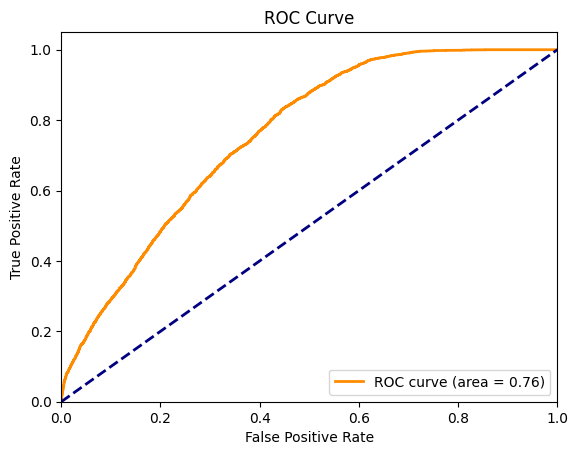

In [21]:
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)


# Calculate AUC-ROC
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


# SMOTE-ENN  with selected columns

In [22]:
df_scaled['applicant_sex'].value_counts()

applicant_sex
0.0    35620
0.2    14030
1.0       21
0.4       17
Name: count, dtype: int64

In [23]:
# Define the minority classes for each column
minority_classes = {
    'applicant_sex': [0.2, 1.0, 0.4],
    'co_applicant_sex': [0.0, 1.0],
    'applicant_race_1': [0.0],
    'co_applicant_race_1': [0.0],
    'applicant_ethnicity_1': [0.0],
    'co_applicant_ethnicity_1': [0.0],
}

# Create a dictionary to store resampled datasets for each column
resampled_datasets = {}

# Iterate through the columns and apply SMOTE to each
for column, minority_class in minority_classes.items():
    # Select the specific column
    selected_column = df_scaled[column].values.reshape(-1, 1)

    # Define y_min based on the minority class for this column
    y_min = [1 if value in minority_class else 0 for value in df_scaled[column]]

    # Apply SMOTE to the selected column
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled2, y_resampled2 = smote.fit_resample(selected_column, y_min)

    # Store the resampled data in the dictionary
    resampled_datasets[column] = (X_resampled2, y_resampled2)


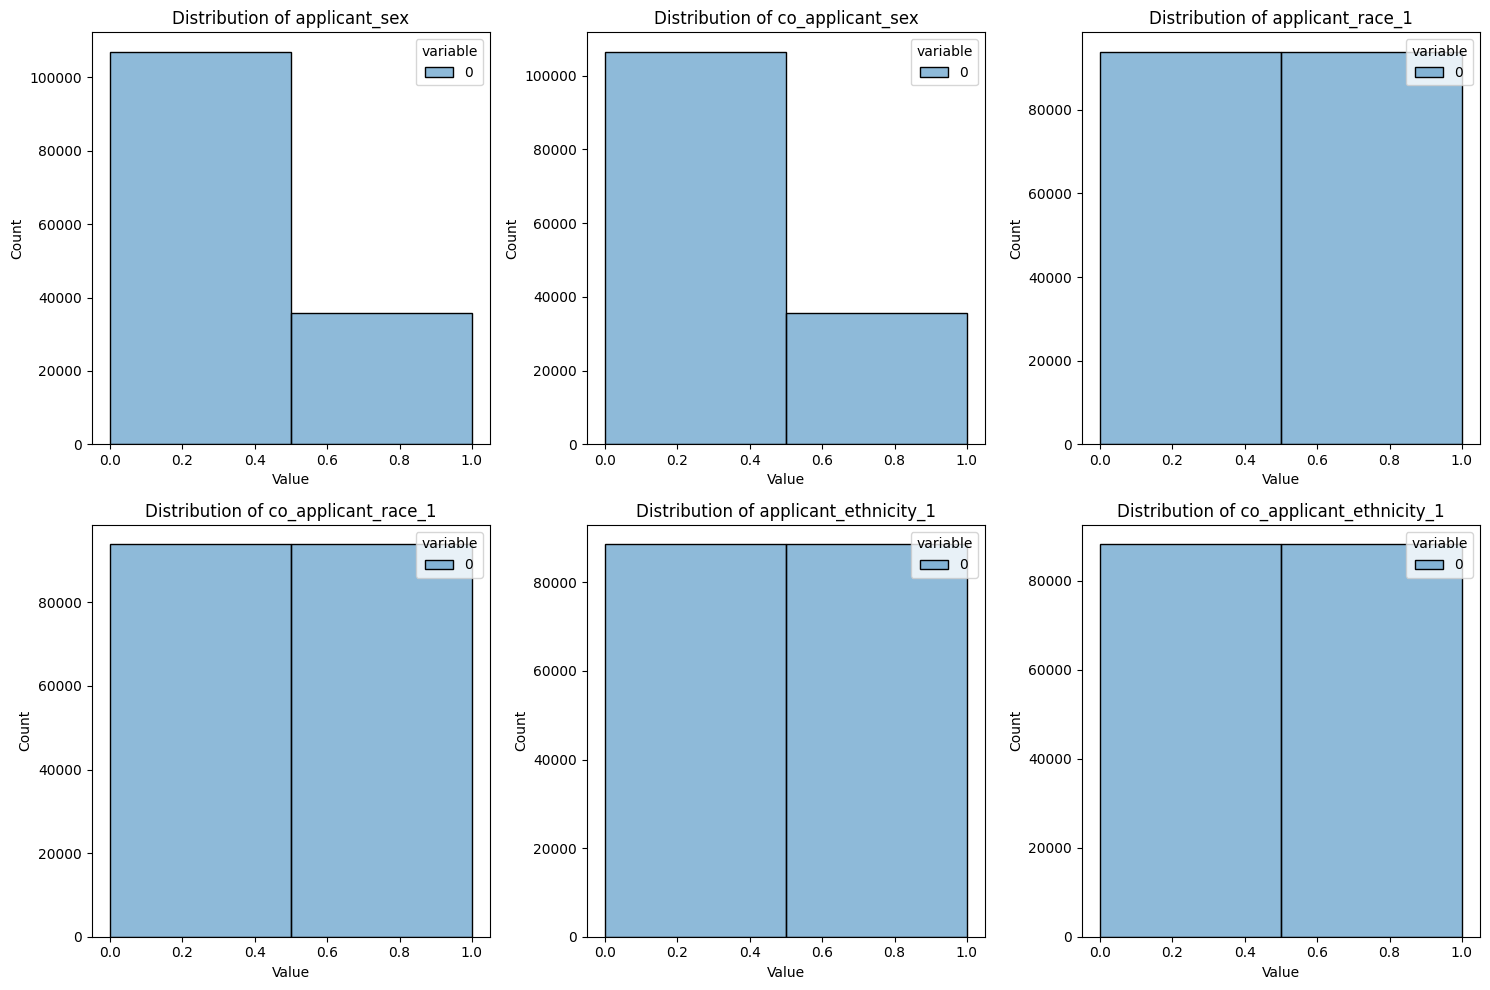

In [24]:
# Create a grid of histograms with 3 plots on every row
columns_to_plot = list(resampled_datasets.keys())

num_plots = len(columns_to_plot)
num_rows = (num_plots // 3) + (num_plots % 3)
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
axes = axes.ravel()

for i, column in enumerate(columns_to_plot):
    X_resampled2, y_resampled2 = resampled_datasets[column]

    merged_data = pd.concat([pd.DataFrame(X_resampled2), pd.DataFrame(y_resampled2)], axis=1)

    g = sns.histplot(data=merged_data.melt(), x='value', hue='variable', binwidth=0.5, ax=axes[i])
    g.set_title(f'Distribution of {column}')
    g.set_xlabel("Value")
    g.set_ylabel("Count")

# Hide any empty subplots
for i in range(num_plots, num_rows * 3):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [25]:
X_resampled2.shape

(88142, 1)

In [26]:
# X_resampled2

In [27]:
# X_resampled2

In [28]:
# Convert the list to a NumPy array
y_resampled2 = np.array(y_resampled2)

# Now you can access the shape
print(y_resampled2.shape)

(88142,)


In [29]:
y_resampled2

array([0, 0, 0, ..., 1, 1, 1])

In [30]:
# Create a SMOTE-ENN instance
smote_enn = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))

# Fit and resample your training data
X_resampled2, y_resampled2 = smote_enn.fit_resample(X_train, y_train)

# Create a regularized logistic regression model with L2 regularization
logistic_reg_smote = LogisticRegression(penalty='l2', C=10, max_iter=10000)

# Fit the model on the resampled training data
logistic_reg_smote.fit(X_resampled2, y_resampled2)

# Make predictions on the test set
y_prob = logistic_reg_smote.predict_proba(X_test)[:, 1]

# Calculate and print the classification report
report = classification_report(y_test, (y_prob > 0.5).astype(int), zero_division=1)
print(report)

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
print("AUC-ROC:", roc_auc)

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob, pos_label=1)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)


              precision    recall  f1-score   support

         0.0       0.86      0.48      0.62      5624
         1.0       0.57      0.90      0.70      4314

    accuracy                           0.66      9938
   macro avg       0.71      0.69      0.66      9938
weighted avg       0.73      0.66      0.65      9938

AUC-ROC: 0.756175846807938
Precision-Recall AUC: 0.6677607774865622


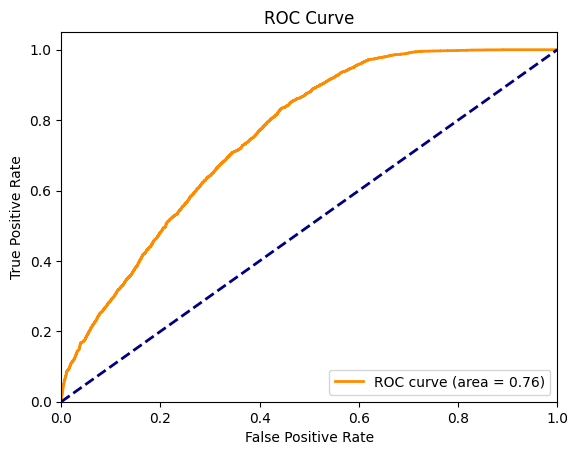

In [31]:
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)


# Calculate AUC-ROC
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [32]:
'''

# Define a grid of hyperparameters to search over
param_grid = {
    'penalty': ['l2', None],
    'C': [10, 100, 1000, 10000],  # Regularization strength
    'max_iter': [1000, 5000, 10000, 50000, 100000]  # Maximum number of iterations
}

# Filter out warnings related to logistic regression
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.linear_model")


# Create a logistic regression model
logistic_reg = LogisticRegression()

# Initialize variables for early stopping
best_auc = -1  # Initialize with a value that's guaranteed to be less than any valid AUC-ROC score
max_patience = 5  # Maximum number of consecutive iterations without improvement before early stopping
patience = 0

for _ in range(50):  # Perform up to 50 iterations
    # Create a GridSearchCV instance with 5-fold cross-validation
    grid_search = GridSearchCV(logistic_reg, param_grid, scoring='roc_auc', cv=5)

    # Fit the grid search to the resampled training data
    grid_search.fit(X_resampled2, y_resampled2)

    # Get the mean AUC-ROC score from cross-validation
    mean_auc = np.mean(grid_search.cv_results_['mean_test_score'])
    
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_params = grid_search.best_params_
        patience = 0  # Reset patience if there's an improvement
    else:
        patience += 1
    
    if patience >= max_patience:
        print("Early stopping: No improvement for {} iterations.".format(max_patience))
        break

# Get the best hyperparameters found
print("Best Hyperparameters:", best_params)

# Create the best model with the best hyperparameters
best_model = LogisticRegression(**best_params)

# Fit the best model to the resampled training data
best_model.fit(X_resampled2, y_resampled2)

# Make predictions on the test set using the best model
y_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate and print the classification report
report = classification_report(y_test, (y_prob > 0.5).astype(int), zero_division=1)
print(report)

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
print("AUC-ROC:", roc_auc)

'''

'\n\n# Define a grid of hyperparameters to search over\nparam_grid = {\n    \'penalty\': [\'l2\', None],\n    \'C\': [10, 100, 1000, 10000],  # Regularization strength\n    \'max_iter\': [1000, 5000, 10000, 50000, 100000]  # Maximum number of iterations\n}\n\n# Filter out warnings related to logistic regression\nwarnings.filterwarnings("ignore", category=UserWarning, module="sklearn.linear_model")\n\n\n# Create a logistic regression model\nlogistic_reg = LogisticRegression()\n\n# Initialize variables for early stopping\nbest_auc = -1  # Initialize with a value that\'s guaranteed to be less than any valid AUC-ROC score\nmax_patience = 5  # Maximum number of consecutive iterations without improvement before early stopping\npatience = 0\n\nfor _ in range(50):  # Perform up to 50 iterations\n    # Create a GridSearchCV instance with 5-fold cross-validation\n    grid_search = GridSearchCV(logistic_reg, param_grid, scoring=\'roc_auc\', cv=5)\n\n    # Fit the grid search to the resampled trai

Best Hyperparameters: {'C': 10000, 'max_iter': 1000, 'penalty': 'l2'}

In [33]:
'''

# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)


# Calculate AUC-ROC
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

'''

'\n\n# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR)\nfpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)\n\n\n# Calculate AUC-ROC\nroc_auc = auc(fpr, tpr)\n\n# Create the ROC curve plot\nplt.figure()\nplt.plot(fpr, tpr, color=\'darkorange\', lw=2, label=\'ROC curve (area = %0.2f)\' % roc_auc)\nplt.plot([0, 1], [0, 1], color=\'navy\', lw=2, linestyle=\'--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'ROC Curve\')\nplt.legend(loc="lower right")\nplt.show()\n\n'

# Final logistic model

In [34]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

# Create a SMOTE-ENN instance
smote_enn = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))

# Fit and resample your training data
X_resampled2, y_resampled2 = smote_enn.fit_resample(X_train, y_train)

# Create a regularized logistic regression model with L2 regularization
logistic_reg_smote = LogisticRegression(C=10000, max_iter=1000, penalty='l2')

# Fit the model on the resampled training data
logistic_reg_smote.fit(X_resampled2, y_resampled2)

# Make predictions on the test set
y_prob = logistic_reg_smote.predict_proba(X_test)[:, 1]

# Calculate and print the classification report
report = classification_report(y_test, (y_prob > 0.5).astype(int), zero_division=1)
print(report)

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
print("AUC-ROC:", roc_auc)

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob, pos_label=1)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)


              precision    recall  f1-score   support

         0.0       0.86      0.48      0.62      5624
         1.0       0.57      0.90      0.70      4314

    accuracy                           0.66      9938
   macro avg       0.71      0.69      0.66      9938
weighted avg       0.73      0.66      0.65      9938

AUC-ROC: 0.7566629060434419
Precision-Recall AUC: 0.6690115827809031


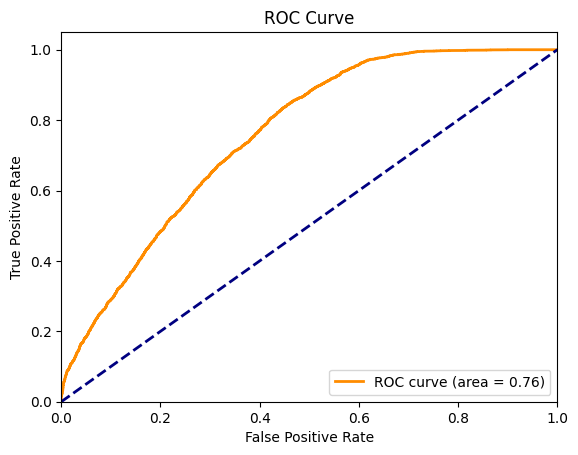

In [35]:
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)


# Calculate AUC-ROC
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# XGBoost (eXtreme Gradient Boosting) 

In [36]:
# Define your hyperparameters
params = {
    'colsample_bytree': 0.7,
    'eval_metric': 'logloss',  # Specify eval_metric during initialization
    'learning_rate': 0.3,
    'max_depth': 3,
    'min_child_weight': 1,
    'missing': -999,
    'n_estimators': 8000,
    'nthread': 4,
    'objective': 'binary:logistic',
    'seed': 1337,
    'subsample': 0.9
}

In [37]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Split X_train and y_train into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [38]:
# Define and initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(**params, early_stopping_rounds=3)

# Set the validation dataset for early stopping
eval_set = [(X_val, y_val)]

In [39]:
# Train the model and monitor early stopping
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Make predictions on the test set
y_predict = (xgb_model.predict_proba(X_test)[:, 1] >= 0.59)

# Calculate precision and recall on the test set
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)

# Print test set results
print("Test set results:")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

from sklearn.metrics import accuracy_score, f1_score

# Calculate other evaluation metrics
accuracy = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Print other evaluation metrics
print("Test set results:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

[0]	validation_0-logloss:0.50676
[1]	validation_0-logloss:0.42353
[2]	validation_0-logloss:0.30203
[3]	validation_0-logloss:0.22436
[4]	validation_0-logloss:0.19961
[5]	validation_0-logloss:0.17492
[6]	validation_0-logloss:0.13646
[7]	validation_0-logloss:0.12442
[8]	validation_0-logloss:0.11322
[9]	validation_0-logloss:0.09154
[10]	validation_0-logloss:0.08438
[11]	validation_0-logloss:0.07027
[12]	validation_0-logloss:0.06061
[13]	validation_0-logloss:0.05724
[14]	validation_0-logloss:0.05060
[15]	validation_0-logloss:0.04605
[16]	validation_0-logloss:0.04417
[17]	validation_0-logloss:0.04183
[18]	validation_0-logloss:0.03919
[19]	validation_0-logloss:0.03709
[20]	validation_0-logloss:0.03537
[21]	validation_0-logloss:0.03431
[22]	validation_0-logloss:0.03266
[23]	validation_0-logloss:0.03146
[24]	validation_0-logloss:0.03051
[25]	validation_0-logloss:0.02963
[26]	validation_0-logloss:0.02886
[27]	validation_0-logloss:0.02832
[28]	validation_0-logloss:0.02770
[29]	validation_0-loglos

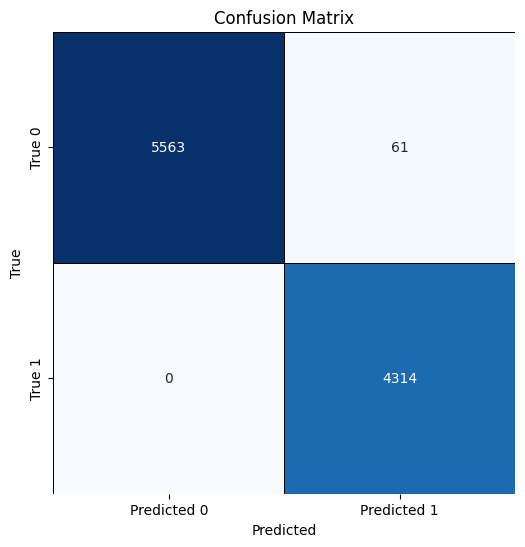

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you already have y_test and y_predict from your code

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black", square=True, cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



In [41]:
import pickle

with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)